# Autoreload and logging config

In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

# configure logging
import logging
logging.basicConfig(level=logging.WARNING)
logging.getLogger('Assignment2RRBSDataSource').setLevel(logging.DEBUG)
logging.getLogger('GlmNetEpigeneticClockTrainer').setLevel(logging.DEBUG)
logging.getLogger('download_file').setLevel(logging.DEBUG)

# Download data files

In [2]:
%%time
import os
from epigenetic_clock_assignment import download_file

data_dir = 'data/assignment2'
#meta_csv_filepath = os.path.join(data_dir, 'MetaPolished.csv')
#features_csv_filepath = os.path.join(data_dir, 'FTGenForGenomicCov_MergeStrands.py-cov5.csv-dropna.py-1.0.csv-Format.py.csv')
#features_zip_filepath = os.path.join(data_dir, 'FTGenForGenomicCov_MergeStrands.py-cov5.csv-dropna.py-1.0.csv-Format.py.csv.zip')

meta_csv_filepath = os.path.join(data_dir, 'MetaPolished.csv')
features_csv_filepath = os.path.join(data_dir, 'FTGenForGenomicCov.py-cov5.csv')
features_zip_filepath = os.path.join(data_dir, 'FTGenForGenomicCov.py-cov5.csv.zip')


# download meta file
download_file(url='https://kerepesi.web.elte.hu/bioinf_ora/MetaPolished.csv',
              out_filepath=meta_csv_filepath)

# download features file if does not exists
download_file(url='https://kerepesi.web.elte.hu/bioinf_ora/FTGenForGenomicCov.py-cov5.csv.zip',
              out_filepath=features_csv_filepath, 
              intermediate_archive_filepath=features_zip_filepath,
              archive_format='zip')


DEBUG:download_file:file data/assignment2/MetaPolished.csv already exists; do not download again
DEBUG:download_file:file data/assignment2/FTGenForGenomicCov.py-cov5.csv already exists; do not download again


CPU times: user 1.7 s, sys: 4.09 s, total: 5.79 s
Wall time: 1.15 s


# Load data

In [3]:
%%time

import os
from epigenetic_clock_assignment import Assignment2RRBSDataSource

data_source = Assignment2RRBSDataSource(
    meta_csv_filepath=meta_csv_filepath,
    features_csv_filepath=features_csv_filepath,
    features_pickle_cache_filepath=os.path.join(data_dir, 'features_cache_mean.pickle'))

X, y, meta_df = data_source.load()

DEBUG:Assignment2RRBSDataSource:load
DEBUG:Assignment2RRBSDataSource:loading features from cache file "data/assignment2/features_cache_mean.pickle"...
DEBUG:Assignment2RRBSDataSource:loaded; shape=(182, 8722093)
DEBUG:Assignment2RRBSDataSource:joining based on ID
DEBUG:Assignment2RRBSDataSource:joined; shape=(182, 8722096)
DEBUG:Assignment2RRBSDataSource:creating y
DEBUG:Assignment2RRBSDataSource:creating X
DEBUG:Assignment2RRBSDataSource:loaded


CPU times: user 5.28 s, sys: 3.62 s, total: 8.91 s
Wall time: 10.1 s


# Hyperparameter optimization (ElasticNet $\lambda, \alpha$)

In [4]:
%%time
from epigenetic_clock_assignment import GlmNetEpigeneticClockTrainer

clock_trainer = GlmNetEpigeneticClockTrainer(
    n_parallel_jobs=1,
    n_cv_fold=10,
    # the weight of standard error used to determine lambda_best, 0 means use lambda_max (see glmnet.ElasticNet)
    std_error_weight_for_lambda_best=0.5,
    seed=43
)

X_train, X_test, y_train, y_test, meta_train, meta_test = clock_trainer.train_test_split(X, y, meta_df,
                                                                  test_size=0.2)

hyperparameter_result, hyperparameter_stats, best_model = clock_trainer.hyperparameter_optimization(
    X_train=X_train, 
    y_train=y_train, 
    alpha_count= 5 + 1)


DEBUG:GlmNetEpigeneticClockTrainer:starting hyperparameter optimization with alpha range [0.  0.2 0.4 0.6 0.8 1. ]
DEBUG:GlmNetEpigeneticClockTrainer:training with alpha 0.0...
DEBUG:GlmNetEpigeneticClockTrainer:training with alpha 0.2...
DEBUG:GlmNetEpigeneticClockTrainer:training with alpha 0.4...
DEBUG:GlmNetEpigeneticClockTrainer:training with alpha 0.6000000000000001...
DEBUG:GlmNetEpigeneticClockTrainer:training with alpha 0.8...
DEBUG:GlmNetEpigeneticClockTrainer:training with alpha 1.0...


CPU times: user 31min 14s, sys: 6min 26s, total: 37min 41s
Wall time: 38min 38s


# Plot hyperparameter optimization result

In [5]:
# filter negative cv_r2_mean (possibly caused by overflow)
hyperparameter_stats_filtered = hyperparameter_stats[hyperparameter_stats['cv_r2_mean']>=0]

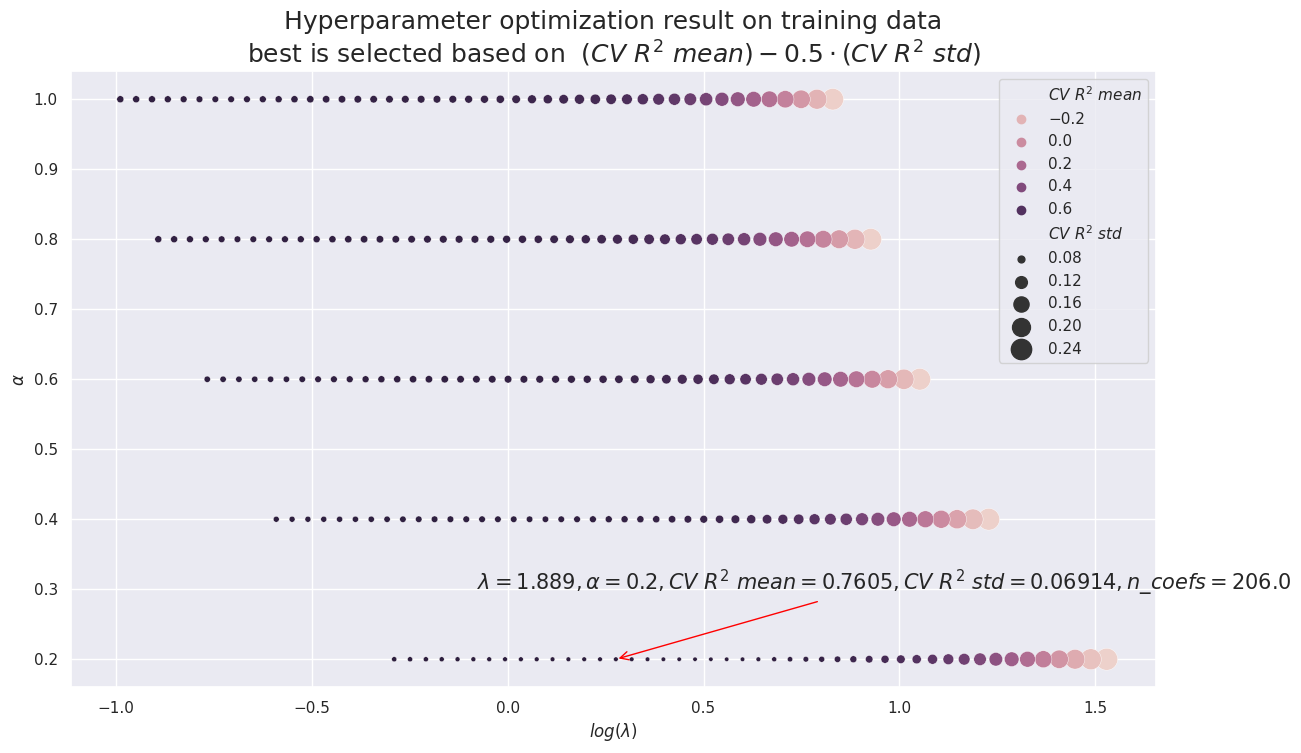

In [6]:
clock_trainer.plot_hyperparameter_optimization_result(
    hyperparameter_result=hyperparameter_result, 
    hyperparameter_stats=hyperparameter_stats_filtered,
    arrow_xytext_offset=(-100, 50))

# Predict on test data using the best model

In [7]:
best_lambda = hyperparameter_result.lambd
best_alpha = hyperparameter_result.alpha

# sanity check
assert best_model.alpha == best_alpha
assert best_model.lambda_best_ == best_lambda

# predict
y_test_pred = best_model.predict(X = X_test, lamb=best_lambda)


# Plot linear regression result on test data

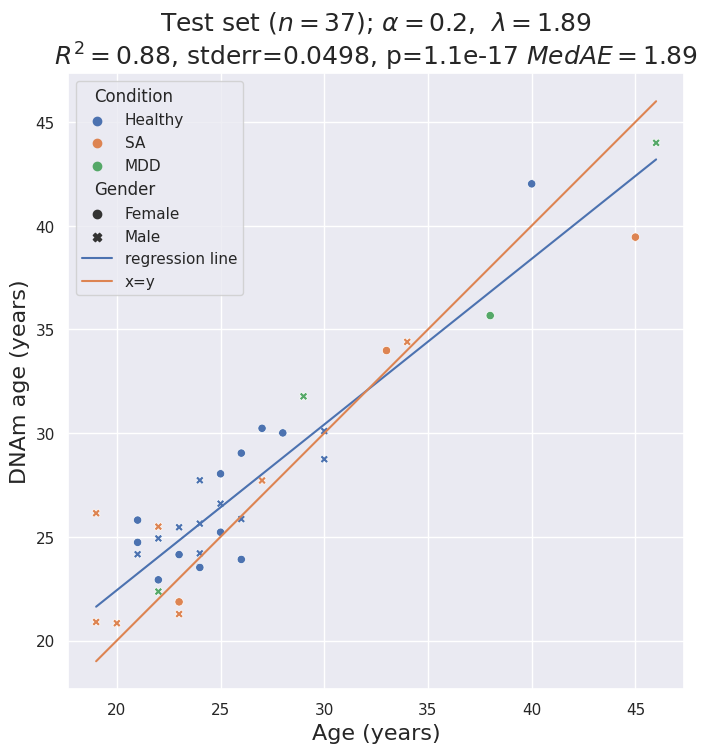

In [8]:
test_stats = clock_trainer.calculate_statistics(y_true=y_test, y_pred=y_test_pred)
clock_trainer.plot_linear_regression_result(
    y_true=y_test, 
    y_pred=y_test_pred, 
    stats=test_stats, 
    alpha=best_alpha, 
    lamb=best_lambda,
    title_prefix='Test set',
    hue=meta_test['Condition'],
    style=meta_test['Gender'])

# Predict on all samples using the best model

In [9]:
# predict
y_pred = best_model.predict(X = X, lamb=best_lambda)

# Plot linear regression result for all samples

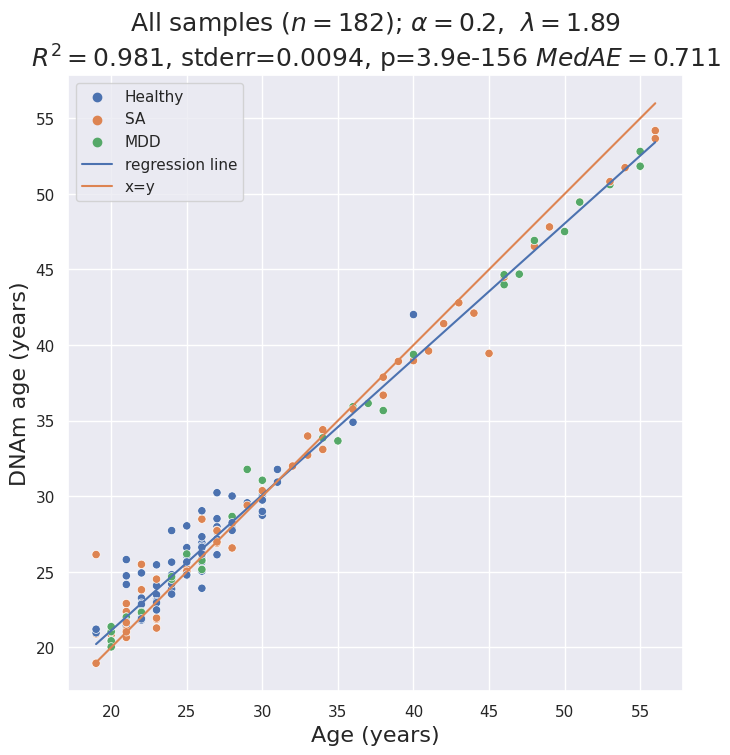

In [10]:
stats = clock_trainer.calculate_statistics(y_true=y, y_pred=y_pred)
clock_trainer.plot_linear_regression_result(
    y_true=y, 
    y_pred=y_pred, 
    stats=stats, 
    alpha=best_alpha, 
    lamb=best_lambda,
    title_prefix='All samples',
    hue=meta_df['Condition'],
    style=None)



# Prepare dataframe for Healthy-MDD-SA comparison

In [11]:
from epigenetic_clock_assignment import HealthyMDDSAStats

# prepare stats
healthy_mdd_sa_stats = HealthyMDDSAStats()

healthy_mdd_sa_stats_df, is_age_normal, is_age_acceleration_norm = healthy_mdd_sa_stats.prepare_stat_dataframe(
    meta_df=meta_df,
    y=y,
    y_pred=y_pred,
    stats=stats)

print('is condition grouped "age" normally distributed?\n', is_age_normal)
print('is condition grouped "age acceleration" normally distributed?\n', is_age_normal)

is condition grouped "age" normally distributed?
            is_normal_p_value
Condition                   
Healthy                False
MDD                    False
SA                     False
is condition grouped "age acceleration" normally distributed?
            is_normal_p_value
Condition                   
Healthy                False
MDD                    False
SA                     False


# Plot Healthy-MDD-SA comparison

(not normally distributed, use Mann-Whitney-Wixocon test)

Healthy vs. MDD: Custom statistical test, P_val:9.958e-01
MDD vs. SA: Custom statistical test, P_val:4.292e-01
Healthy vs. SA: Custom statistical test, P_val:6.270e-01


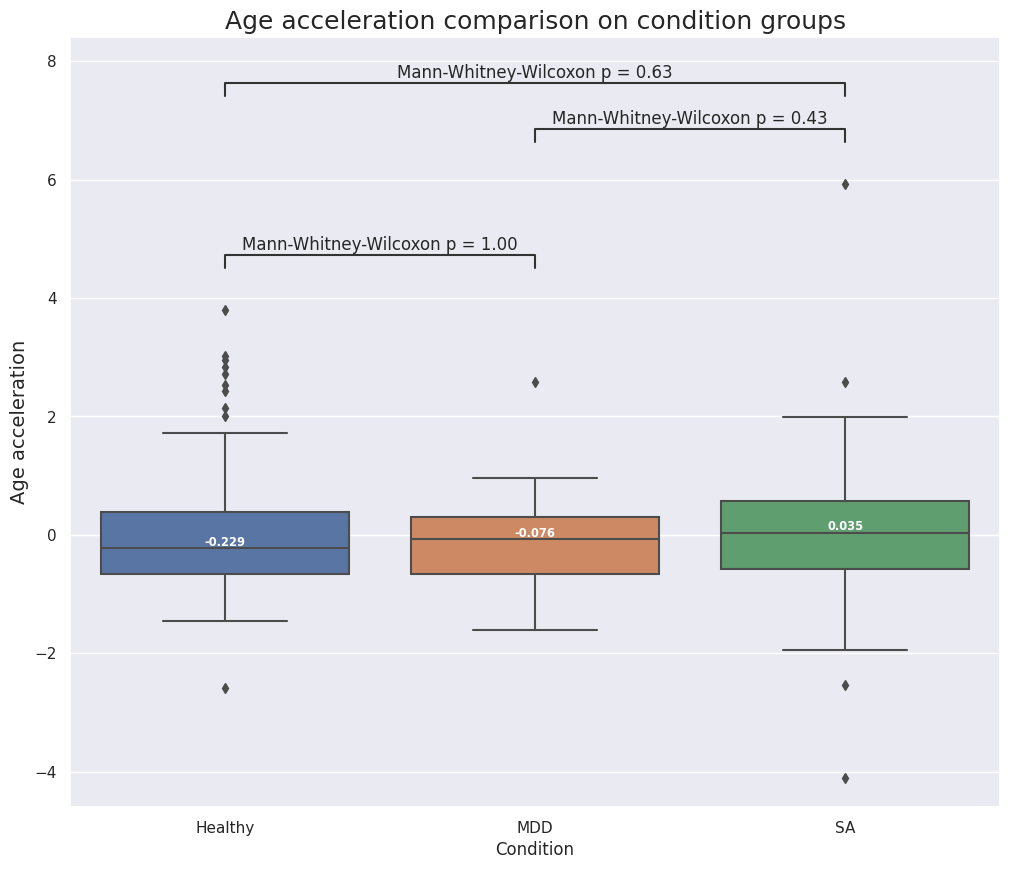

In [12]:
from epigenetic_clock_assignment import HealthyMDDSAPlot

healthy_mdd_sa_plot = HealthyMDDSAPlot()
healthy_mdd_sa_plot.boxplot(healthy_mdd_sa_stats_df, title='Age acceleration comparison on condition groups')


# Histogram for the distribution of the data (colored by condition)

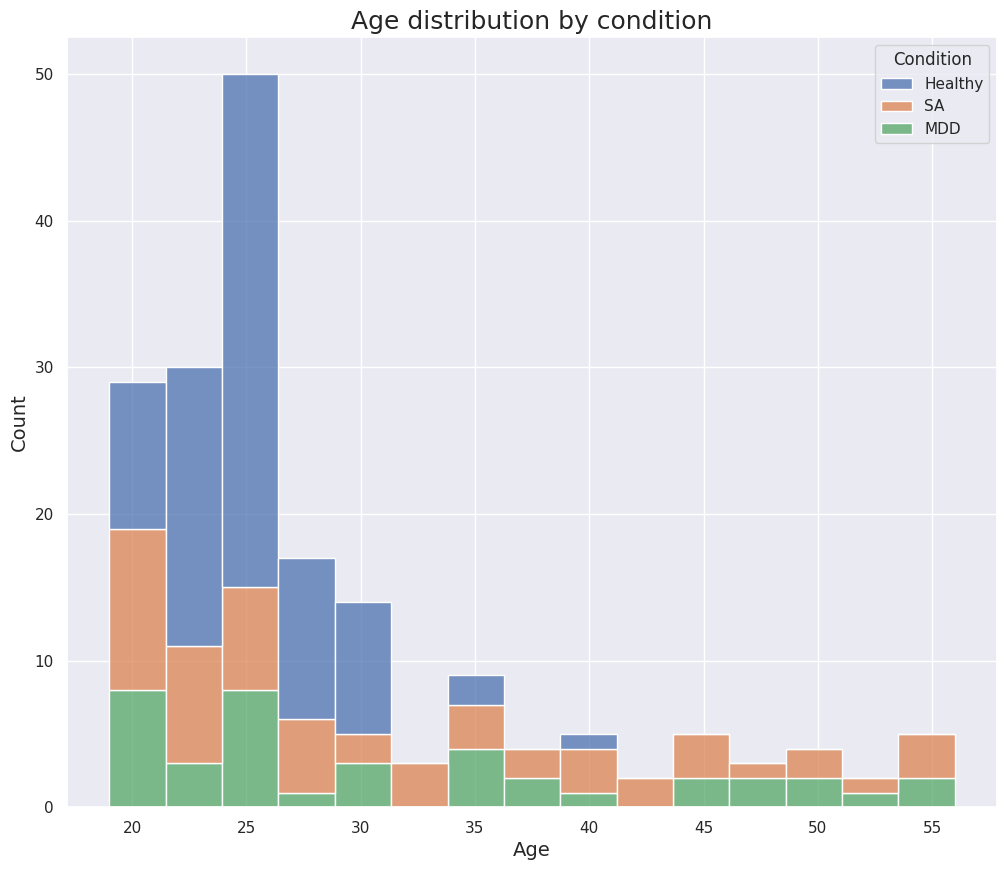

In [13]:
healthy_mdd_sa_plot.age_histogram(healthy_mdd_sa_stats_df)

# Match instances by age to control for inbalanced data

In [14]:
healthy_mdd_sa_controlled_df = healthy_mdd_sa_stats.control_for_imbalanced_age(healthy_mdd_sa_stats_df, tolerance_year=1)

# Plot controlled Healthy-MDD-SA comparison

Healthy vs. MDD: Custom statistical test, P_val:7.913e-01
MDD vs. SA: Custom statistical test, P_val:7.555e-01
Healthy vs. SA: Custom statistical test, P_val:3.743e-01


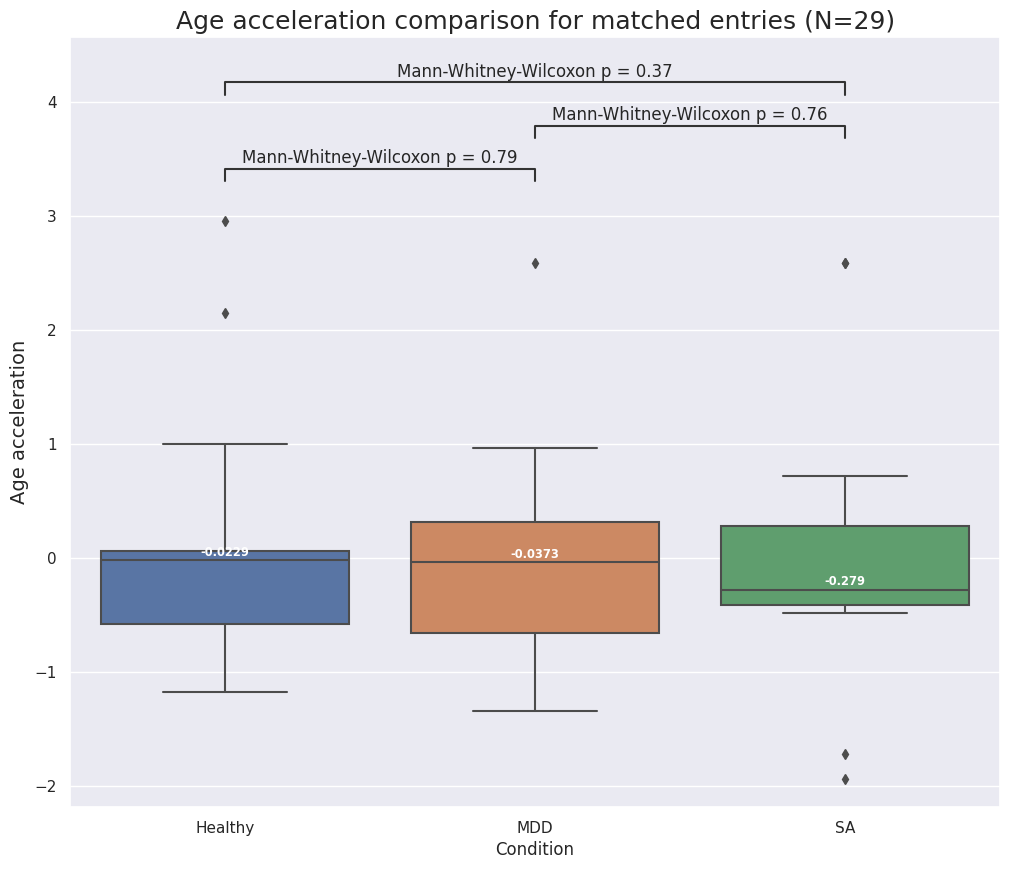

In [15]:
healthy_mdd_sa_plot = HealthyMDDSAPlot()
healthy_mdd_sa_controlled_instance_count = int(healthy_mdd_sa_controlled_df.shape[0]/3)
healthy_mdd_sa_plot.boxplot(healthy_mdd_sa_controlled_df, title=f'Age acceleration comparison for matched entries (N={healthy_mdd_sa_controlled_instance_count})')